In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from collections import Counter
from ta.momentum import *
from ta.volume import *
from ta.trend import *
from ta.volatility import *
import matplotlib.pyplot as plt

In [2]:
data = pd.read_pickle('C:/Users/alexm/Desktop/pythonstuff/capstone/storage/rawdata/data.pickle')
meta = pd.read_pickle('C:/Users/alexm/Desktop/pythonstuff/capstone/storage/rawdata/meta.pickle')
#data2 = pd.read_pickle('C:/Users/alexm/Desktop/pythonstuff/capstone/storage/rawdata/data2.pickle')

In [3]:
meta.head()

,Ticker,GICS Sector,GICS Sub-Industry
0,MMM,Industrials,Industrial Conglomerates
1,ABT,Health Care,Health Care Equipment
2,ABBV,Health Care,Pharmaceuticals
3,ABMD,Health Care,Health Care Equipment
4,ACN,Information Technology,IT Consulting & Other Services


In [4]:
#remove tickers with adj Close from whichever dataset u choose
this_set = data
rem_cols = list()
for i in range(this_set.columns.shape[0]):
  if this_set.columns[i][1] == 'Adj Close':
    rem_cols.append(this_set.columns[i])
new_data = this_set.drop(rem_cols,axis=1)

In [5]:
#interpolate missing values with limit of 2 consecutive NaNs
new_data = new_data.interpolate('linear',limit=2)

In [6]:
new_data.isnull().sum().sum()

9510

In [7]:
#find ticks to remove that have too many consecutive NaNs
rem_ticks = []
for j in meta['Ticker']:
  test = (new_data[j].isna().sum() > 0)
  if any(test):
    rem_ticks.append(j)

In [8]:
#we only need to remove 6 ticks
len(rem_ticks)

6

In [9]:
new_data = new_data.drop(rem_ticks,axis=1)

In [11]:
new_meta = meta
for j in range(len(rem_ticks)):
    new_meta = new_meta[new_meta.Ticker != rem_ticks[j]]

In [12]:
new_meta = new_meta.reset_index()
new_meta = new_meta.drop('index',axis=1)

In [13]:
new_meta

,Ticker,GICS Sector,GICS Sub-Industry
0,MMM,Industrials,Industrial Conglomerates
1,ABT,Health Care,Health Care Equipment
2,ABBV,Health Care,Pharmaceuticals
3,ABMD,Health Care,Health Care Equipment
4,ACN,Information Technology,IT Consulting & Other Services
...,...,...,...
494,YUM,Consumer Discretionary,Restaurants
495,ZBRA,Information Technology,Electronic Equipment & Instruments
496,ZBH,Health Care,Health Care Equipment
497,ZION,Financials,Regional Banks


In [14]:
#remove volume
rem_inds = list()
for j in new_meta['Ticker']:
    if (j,'Volume') in new_data.columns:
        rem_inds.append((j,'Volume'))
new_data = new_data.drop(rem_inds,axis=1)    

In [15]:
n_features = 14

In [16]:
#adding TIs to new_data frame
fillmas = True
fill = False
for j in new_meta['Ticker']:

    #TIs
    close = new_data[j]['Close']
    #BBs
    bols = BollingerBands(close=close,window=7*15,window_dev=2,fillna=fill)
    hband = bols.bollinger_hband()
    lband = bols.bollinger_lband()
    #SMAs
    sma25 = sma_indicator(close=close,window=7*17,fillna=fillmas)
    sma50 = sma_indicator(close=close,window=7*35,fillna=fillmas)
    sma100 = sma_indicator(close=close,window=7*90,fillna=fillmas)
    #EMAs
    ema25 = ema_indicator(close=close,window=7*25,fillna=fillmas)
    ema50 = ema_indicator(close=close,window=7*50,fillna=fillmas)
    ema100 = ema_indicator(close=close,window=7*70,fillna=fillmas)
    #MACD
    macd = MACD(close=close,window_fast=7*10,window_slow=7*18,fillna=fill)
    macdline = macd.macd()
    #RSI
    rsi = RSIIndicator(close=close,window=7*14,fillna=fill)
    rsiline = rsi.rsi()

    
    new_data[j,'SMA25'] = sma25
    new_data[j,'SMA50'] = sma50
    new_data[j,'SMA100'] = sma100
    new_data[j,'EMA25'] = ema25
    new_data[j,'EMA50'] = ema50
    new_data[j,'EMA100'] = ema100
    new_data[j,'MACD'] = macdline
    new_data[j,'RSI'] = rsiline
    new_data[j,'H_BAND'] = hband
    new_data[j,'L_BAND'] = lband
    new_data = new_data.sort_index(axis=1)



(18365.5625, 18726.8125)

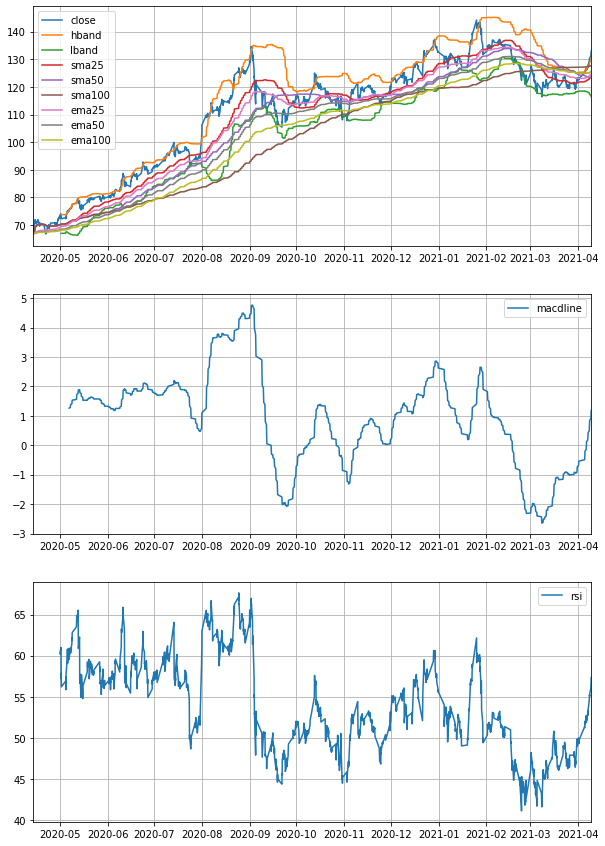

In [19]:
aapl = new_data['AAPL']
close = aapl['Close']
hband = aapl['H_BAND']
lband = aapl['L_BAND']
sma25 = aapl['SMA25']
sma50 = aapl['SMA50']
sma100 = aapl['SMA100']
ema25 = aapl['EMA25']
ema50 = aapl['EMA50']
ema100 = aapl['EMA100']
macdline = aapl['MACD']
rsiline = aapl['RSI']
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(311)
plt.plot(close)
plt.plot(hband)
plt.plot(lband)
plt.plot(sma25)
plt.plot(sma50)
plt.plot(sma100)
plt.plot(ema25)
plt.plot(ema50)
plt.plot(ema100)
plt.legend(['close','hband','lband','sma25','sma50','sma100','ema25','ema50','ema100'])
plt.grid('on')
plt.xlim(close.index[0],close.index[-1])
ax2 = fig.add_subplot(312)
plt.plot(macdline)
plt.grid('on')
plt.xlim(close.index[0],close.index[-1])
plt.legend(['macdline'])
ax3 = fig.add_subplot(313)
plt.plot(rsiline)
plt.legend(['rsi'])
plt.grid('on')
plt.xlim(close.index[0],close.index[-1])

In [22]:
new_data = new_data.dropna()

In [23]:
X = np.zeros((new_meta.shape[0],new_data.shape[0],n_features))
i = 0
for j in new_meta['Ticker']:
  X[i] = new_data[j]
  i += 1

In [24]:
print(new_data.shape)
print(new_meta.shape)
print(X.shape)

(1616, 6986)
(499, 3)
(499, 1616, 14)


In [25]:
os.getcwd()

'c:\\Users\\alexm\\Desktop\\pythonstuff\\capstone'

In [26]:
pd.to_pickle(new_data,'./storage/1yeardata/data.pickle' )
pd.to_pickle(new_meta,'./storage/1yeardata/meta.pickle')
np.save('./storage/1yeardata/X.npy',X)